In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [42]:
df = pd.read_csv("../Data/raw_analyst_ratings.csv/raw_analyst_ratings.csv")


#### Descriptive Statistics
1.  Obtain basic statistics for textual lengths (like headline length).
    * Calculate the number of characters or words in each news headline.

    * Analyze the distribution (e.g., average, median, max, min headline lengths).

    Why It’s Important:
    *   Signal strength: Longer headlines might carry more detailed or significant information.

    * Noise detection: Extremely short or long headlines could be outliers or irrelevant.

    * Feature engineering: Headline length itself can be used as a numerical feature in your ML model. For example, urgent news might have short punchy headlines (“Apple crashes 12%”) which correlate with big stock moves.


2. Count the number of articles per publisher to identify which publishers are most active.
    Why It’s Important:
    * Publisher bias: Some publishers may report more positively or negatively about certain stocks.

    * Data reliability: Publishers with too few articles may not provide enough data to be useful.

    * Weighting: You may want to give more weight to more reputable or more frequently publishing sources.

    * Source pattern recognition: Identify which publishers tend to write before significant stock movements.

3. Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.
    Why It’s Important:
    * Market reaction timing: You may find that stock prices respond differently depending on when news is published (e.g., weekday vs weekend).

    * Volume signal: A spike in articles could indicate a significant event worth modeling.

    * Seasonality: Some companies or sectors might have regular cycles of news (e.g., quarterly earnings).

In [43]:
df['headline_length']=df['headline'].apply(lambda x: len(str(x)))
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


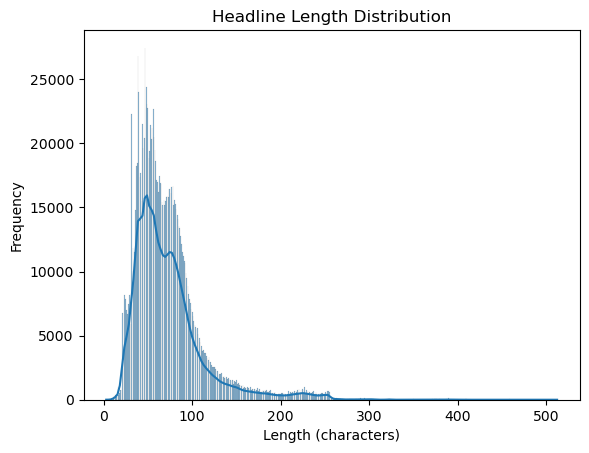

In [44]:

sns.histplot(df['headline_length'], kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


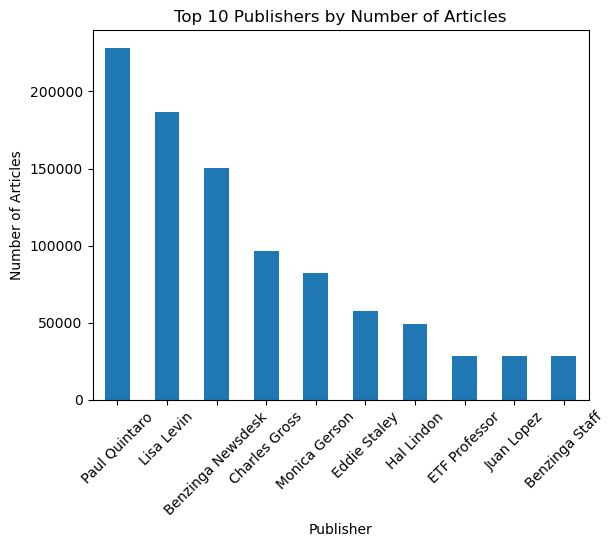

In [45]:
publisher_counts = df['publisher'].value_counts()

print(publisher_counts.head(10)) 

publisher_counts.head(10).plot(kind='bar')
plt.title("Top 10 Publishers by Number of Articles")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()


In [46]:
# df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)


In [47]:
print(df['date'].dtype)  # should print: datetime64[ns, tz] or datetime64[ns]


datetime64[ns, UTC]


Extract useful date components

In [48]:
df['date_only'] = df['date'].dt.date


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df['hour'] = df['date'].dt.hour

df['date_utc'] = df['date'].dt.tz_convert('UTC')


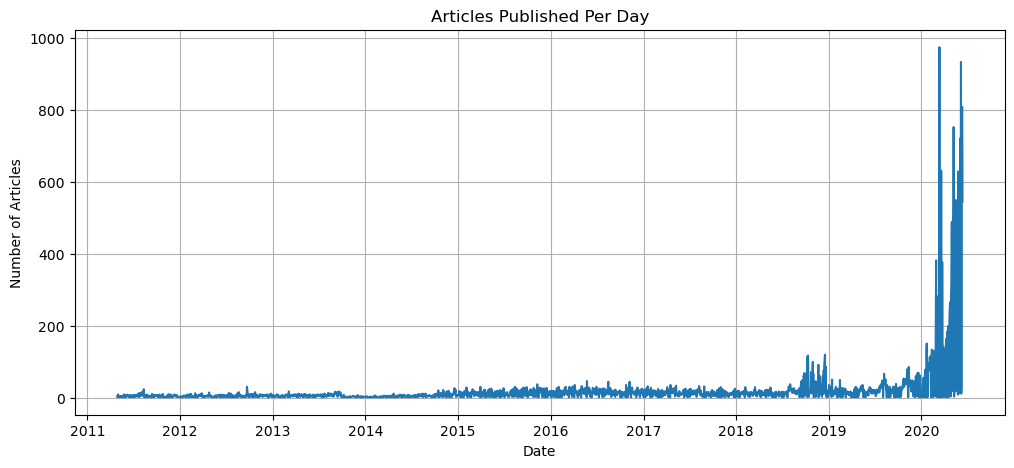

In [49]:
# Count articles published per day
daily_counts = df.groupby(df['date_only']).size()

daily_counts.plot(figsize=(12, 5), title="Articles Published Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()


Analyze time-of-day

Text(0, 0.5, 'Number of Articles')

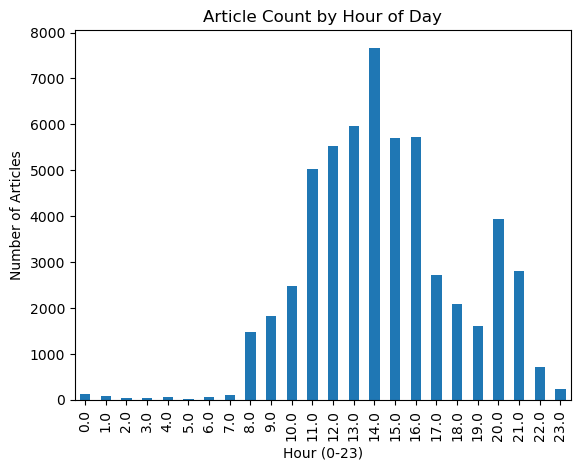

In [50]:
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Article Count by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Number of Articles")


Check weekday trends

Text(0.5, 1.0, 'Articles per Weekday')

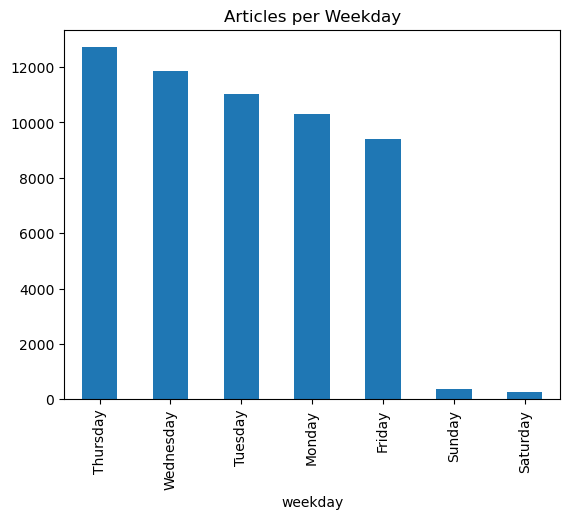

In [51]:
df['weekday'] = df['date'].dt.day_name()
df['weekday'].value_counts().plot(kind='bar')
plt.title("Articles per Weekday")


#### Text Analysis with Topic Modeling
This step is useful for discovering patterns and hidden themes in your news articles. For example, it helps answer questions like:

* What are the main topics discussed across articles?
* Are there recurring events (e.g., "FDA approval", "acquisition", "price hike")?
* Can we cluster articles based on themes?

 Why is Topic Modeling Important?

* Understanding content at scale: If you have thousands of articles, manually labeling them is impossible. Topic modeling groups them for you.
* Trend detection: Helps spot what topics were hot during certain time periods.
* Filtering & Summarization: You can highlight or recommend content by topic without reading everything.

##### Preprocess the Text

In [52]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

df['clean_text'] = df['headline'].astype(str).apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Vectorize the Text

In [53]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['clean_text'])

##### Apply LDA
Latent Dirichlet Allocation (LDA) is a topic modeling algorithm that helps discover hidden topics in a large collection of text (like news articles or documents). It was introduced by David Blei, Andrew Ng, and Michael Jordan in 2003.

##### How it works (Intuition):
LDA assumes

1. Each document (headline/article) is a mixture of topics.

2. Each topic is a mixture of words.

So, for example:

* A headline like "Pfizer gets FDA approval for new vaccine" could be:

    * 70% Topic A (Medical news)

    * 30% Topic B (Pharmaceutical market)

Each topic has its own most common words. LDA finds these distributions using math (probability and Bayesian inference).



In [54]:

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)


LatentDirichletAllocation(n_components=5, random_state=42)

##### Show the Topics

In [55]:
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]]))
        print()

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)


Topic 1:
update | ceo | deal | analyst | new | share | reports | announces | says | shares

Topic 2:
yesterday | announces | coverage | sees | initiates | estimate | sales | reports | eps | est

Topic 3:
stock | highs | industry | hit | markets | earnings | update | week | stocks | market

Topic 4:
lowers | companies | downgrades | raises | target | maintains | buy | trading | price | shares

Topic 5:
upgrades | etfs | watch | scheduled | premarket | moving | session | earnings | benzingas | stocks



In [56]:
print(df['date'].dtype)

datetime64[ns, UTC]


In [57]:
df['date_only'] = df['date'].dt.date
daily_counts = df.groupby('date_only').size()

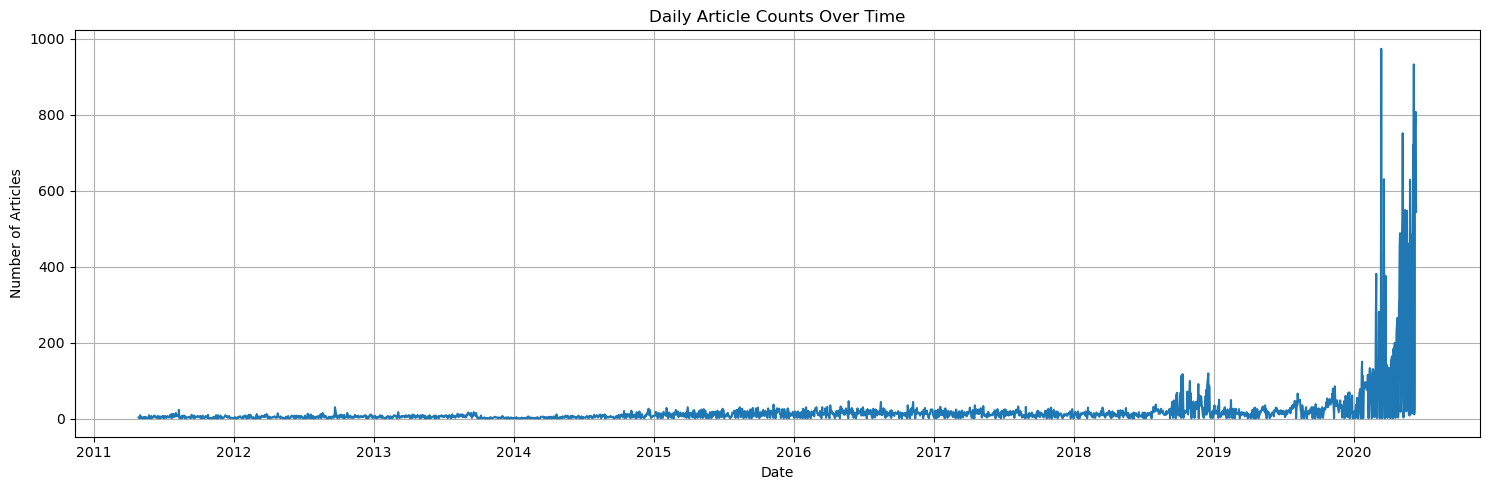

In [58]:
plt.figure(figsize=(15, 5))
daily_counts.plot()
plt.title('Daily Article Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# Show top 5 days with the highest article counts
print(daily_counts.sort_values(ascending=False).head())


date_only
2020-03-12    973
2020-06-05    932
2020-06-10    807
2020-06-09    803
2020-06-08    765
dtype: int64


#### Hourly publication pattern (within a day)

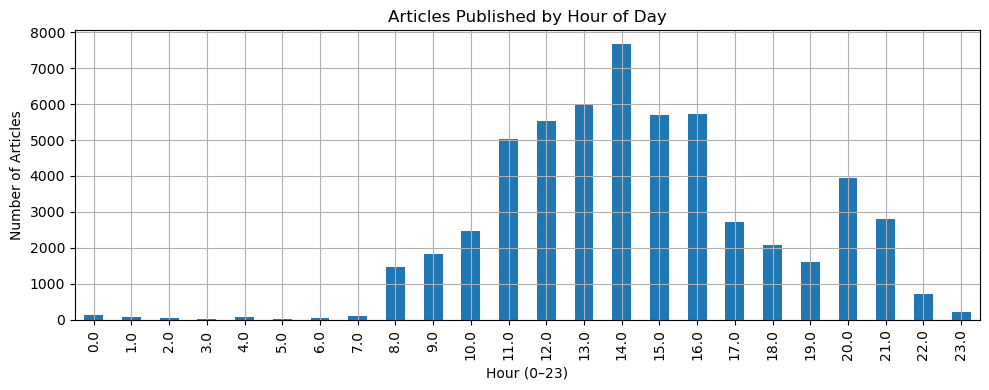

In [60]:
df['hour'] = df['date'].dt.hour
hourly_counts = df.groupby('hour').size()

# Plot
plt.figure(figsize=(10, 4))
hourly_counts.plot(kind='bar')
plt.title('Articles Published by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Publisher Analysis to answer:

* Who contributes most to the news feed?
* Do publishers differ in what they report?
* Are certain email domains dominant (e.g., @reuters.com, @bloomberg.net)?

##### Top Publishers

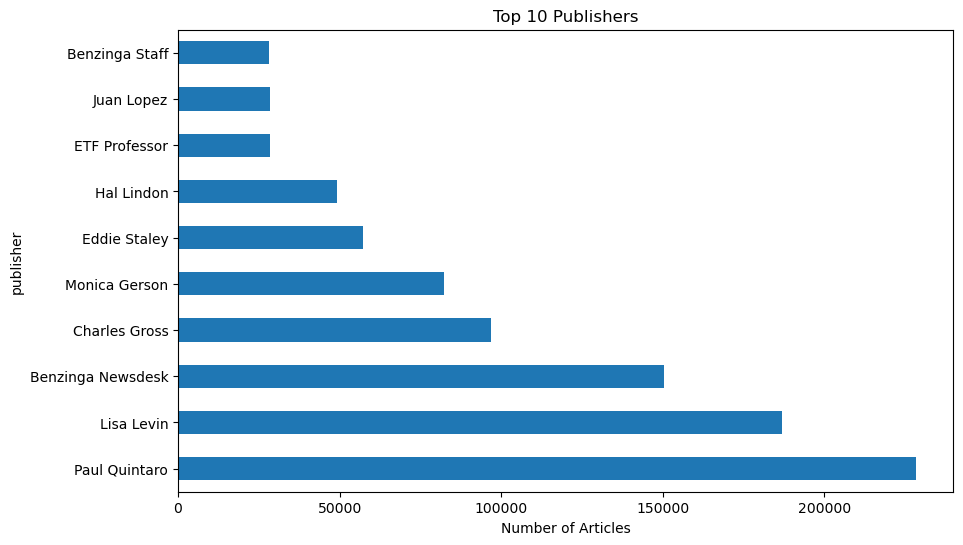

In [64]:
top_publishers = df['publisher'].value_counts().head(10)
top_publishers.plot(kind='barh', figsize=(10,6), title='Top 10 Publishers')
plt.xlabel("Number of Articles")
plt.show()


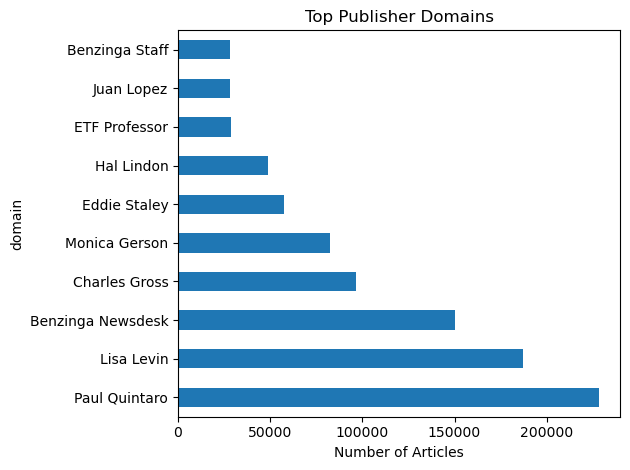

In [ ]:
df['domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')
df['domain'] = df['domain'].fillna(df['publisher'])  # fallback if no email format

df['domain'].value_counts().head(10).plot(kind='barh', title='Top Publisher Domains')
plt.xlabel("Number of Articles")
plt.tight_layout()
plt.show()
